In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
import joblib


In [9]:
# Load dataset
df = pd.read_csv('C:/Users/sahit/Desktop/RTRP/dataset/data/data1.csv')

In [10]:
# Ensure the necessary nltk resources are downloaded
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sahit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sahit\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sahit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
# Function to clean text
def tokenize_remove_punctuation(text):
    clean_text = []
    text = text.split(" ")
    for word in text:
        word = list(word)
        new_word = []
        for c in word:
            if c not in string.punctuation:
                new_word.append(c)
        word = "".join(new_word)
        clean_text.append(word)
    return clean_text

In [12]:
def remove_stopwords(text):
    stopwords_list = set(stopwords.words('english'))
    return [word for word in text if word not in stopwords_list]

def pos_tagging(text):
    try:
        return nltk.pos_tag(text)
    except Exception as e:
        print(e)
        return []

In [13]:
def get_wordnet(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [14]:

def clean_text(text):
    text = str(text).lower()
    text = tokenize_remove_punctuation(text)
    text = [word for word in text if not any(c.isdigit() for c in word)]
    text = remove_stopwords(text)
    text = [t for t in text if len(t) > 0]
    pos_tags = pos_tagging(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet(t[1])) for t in pos_tags]
    text = [t for t in text if len(t) > 1]
    return " ".join(text)

In [15]:

# Clean 'comments' column
df['Processed_Comment'] = df['comments'].map(clean_text)

In [16]:

# Convert 'tagging' to integer
df['tagging'] = df['tagging'].astype(str).astype(int)

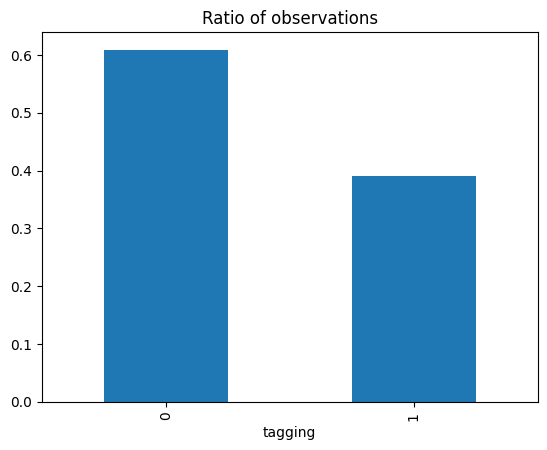

In [17]:
# Visualize the distribution of the 'tagging' column
df['tagging'].value_counts(normalize=True).plot(kind='bar', title='Ratio of observations')
plt.show()

In [18]:

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Processed_Comment'], df['tagging'], random_state=42, test_size=0.20)

In [19]:

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
joblib.dump(tokenizer, 'model/tokenizer.pkl')
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [20]:
# Pad the sequences
max_sequence_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)


In [21]:

# Define the model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_sequence_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

c:\Users\sahit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:

# Compile the model 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:

# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Train the model
batch_size = 32
epochs = 5

In [25]:
history = model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_padded, y_test), verbose=1)
model.save("model/cyberbullying_model.h5")


Epoch 1/5


500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 55ms/step - accuracy: 0.6659 - loss: 0.5938 - val_accuracy: 0.7671 - val_loss: 0.4718
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 46s 93ms/step - accuracy: 0.8326 - loss: 0.3655 - val_accuracy: 0.8228 - val_loss: 0.3990
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 48s 95ms/step - accuracy: 0.9010 - loss: 0.2488 - val_accuracy: 0.8383 - val_loss: 0.3875
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 86ms/step - accuracy: 0.9303 - loss: 0.1799 - val_accuracy: 0.8580 - val_loss: 0.3732
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.9446 - loss: 0.1439 - val_accuracy: 0.8583 - val_loss: 0.3855


In [26]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

# Retrieve training accuracy from history
training_accuracy = history.history['accuracy'][-1]
print(f'Training Accuracy: {training_accuracy:.4f}')

Validation Loss: 0.3855
Validation Accuracy: 0.8583
Training Accuracy: 0.9439


In [27]:

# Predict the labels for the test set
y_test_pred = (model.predict(X_test_padded) > 0.5).astype("int32")

126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


In [28]:
# Calculate F1-score, recall, and precision
f1 = f1_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)


In [29]:
# Function to predict if the text is cyberbullying or not
def predict_cyberbullying(text, tokenizer, model, max_sequence_length):
    clean_text_input = clean_text(text)
    sequence = tokenizer.texts_to_sequences([clean_text_input])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    prediction = model.predict(padded_sequence)
    return 'Cyberbullying' if prediction >= 0.5 else 'Non-cyberbullying'

In [30]:

# Function to find and print the prediction result
def find(user_text):
    result = predict_cyberbullying(user_text, tokenizer, model, max_sequence_length)
    return result

: 